In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import configs
import os
from scipy.stats import sem
import matplotlib.cm as cm

In [2]:
plt.rcParams['font.family'] = 'sans-serif'

In [3]:
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'

# Helper functions

In [23]:
def plot(
    df, plot_key, plot_ep,
    fnames=None, figname=None,
    smooth_line=True, smooth_n=5, smooth_plot=True, colors=None,
    legend_title='Auxiliary Task'):
    
    fig, ax = plt.subplots()
    zs = np.sort(np.unique(df['z']))
    episode = np.sort(np.unique(df['episode']))
    if fnames is None:
        fnames = np.unique(df['model'])
    for fname_idx, fname in enumerate(fnames):
        line = []
        shading_lower = []
        shading_upper = []
        for z in zs:
            means = []
            sems = []
            df_subset = df[(df['model']==fname) & (df['z']==z)]
            for ep in episode:
                vals = df_subset[df_subset['episode']==ep]
                vals = vals[plot_key]
                means.append(np.mean(vals))
                sems.append(sem(vals))
            means = np.array(means)
            sems = np.array(sems)
            mean_lowerbound = means - sems
            mean_upperbound = means + sems
            if smooth_line:
                means = smooth(episode, means, smooth_n)
                mean_lowerbound = smooth(episode, mean_lowerbound)
                mean_upperbound = smooth(episode, mean_upperbound)
            line.append(means[plot_ep])
            shading_lower.append(mean_lowerbound[plot_ep])
            shading_upper.append(mean_upperbound[plot_ep])
        if smooth_plot:
            _line = smooth(zs, line, 2)
            _shading_lower = smooth(zs, shading_lower, 2)
            _shading_upper = smooth(zs, shading_upper, 2)
            _line[0] = line[0]; _line[-1] = line[-1]
            _shading_lower[0] = shading_lower[0]
            _shading_lower[-1] = shading_lower[-1]
            _shading_upper[0] = shading_upper[0]
            _shading_upper[-1] = shading_upper[-1]
            line = _line; shading_lower = _shading_lower;
            shading_uppper = _shading_upper
        x_axis = zs
        if colors is not None:
            color = colors[fname_idx]
        else:
            color = None
        ax.plot(x_axis, line, label=fname, color=color, alpha=0.8)
        ax.fill_between(x_axis, shading_lower, shading_upper, alpha=0.2,color=color)
    plt.ylabel('Avg Episode Score')
    plt.xlabel('Latent Dimensions')
    #plt.xticks([0.75, 1, 1.25], ['$0.75$x', '$1$x', '$1.25$x'])
    plt.legend(title=legend_title, title_fontsize=14)
    #plt.ylim(-0.05, 1.05)
    plt.tight_layout()
    if figname != None:
        plt.savefig(figname+'.png', dpi=300)
    plt.show()

In [5]:
def smooth(xs, ys, n=3):
    return np.convolve(ys, np.ones(n)/n, mode='same')

In [6]:
def get_df(base, zs):
    data = {
        'valid_score': [], 'valid_steps':[], 'dims': [],
        'episode': [], 'model': [], 'z': [], 'step': []}
    for z in zs:
        task_dir = f'{base}_dm_dim{z}'
        task_dir = f'{engram_dir}pickles/{task_dir}/'
        if not os.path.exists(task_dir): continue
        for pickle_file in os.listdir(task_dir):
            if not pickle_file.endswith('.p'): continue
            pickle_file = f'{task_dir}{pickle_file}'
            with open(pickle_file, 'rb') as f:
                results = pickle.load(f)
            valid_score = results['valid_score']
            valid_steps = results['valid_steps_per_ep']
            episode = results['episode']
            model = results['model']
            step = results['step']
            for i in range(len(valid_score)):
                if valid_score[i] == None: continue
                data['valid_score'].append(valid_score[i])
                data['valid_steps'].append(valid_steps[i])
                data['dims'].append(z)
                data['episode'].append(episode[i])
                _model = model[i].split(base+'_')[-1]
                data['model'].append(_model)
                data['z'].append(z)
                data['step'].append(step[i])
    df = pd.DataFrame(data)
    return df

# Task A Results

In [200]:
zs = np.arange(2, 20)

In [201]:
taskA_df = get_df('gridworld8x8', zs)

In [202]:
np.unique(taskA_df['model'])

array(['entro_0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0',
       'g0_-2_entro0'], dtype=object)

In [203]:
# entro_0
# g0_-2
# g0_-2_entro0
# g0.25_-3
# g0.25_-3_entro0
# g0.5_-3
# g0.5_-3_entro0
# g0.8_-3 # -4 might be better
# g0.8_-4_entro0

/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


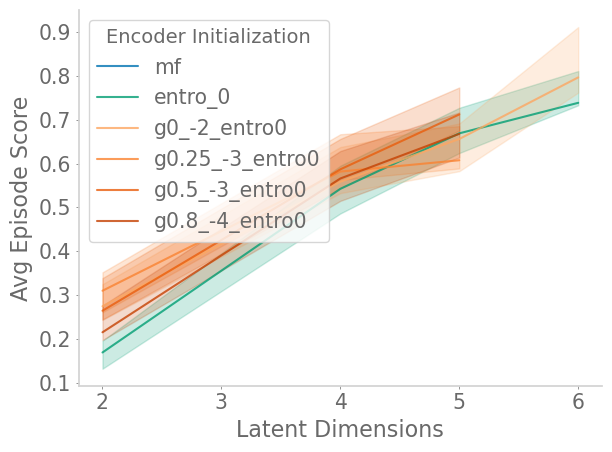

In [204]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskA_df, 'valid_score',
    100,
    smooth_line=True, smooth_n=20,
    fnames=['mf', 'entro_0', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0'],
    smooth_plot=False,
    figname='gridworld6x6_taskA_early', legend_title='Encoder Initialization',
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
     )

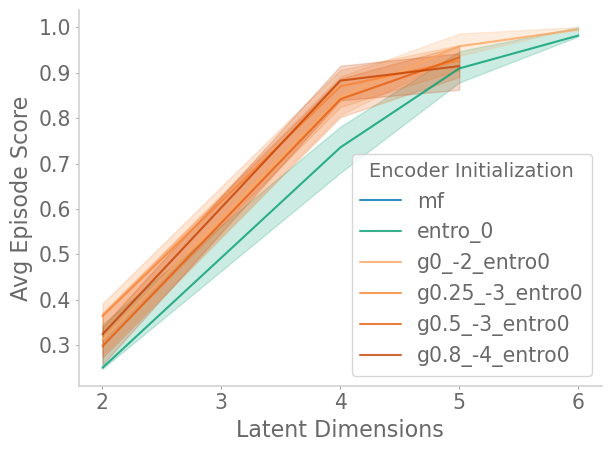

In [205]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskA_df, 'valid_score',
    180,
    smooth_line=True, smooth_n=20,
    fnames=['mf', 'entro_0', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0'],
    smooth_plot=False,
    figname='gridworld6x6_taskA_late', legend_title='Encoder Initialization',
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
     )

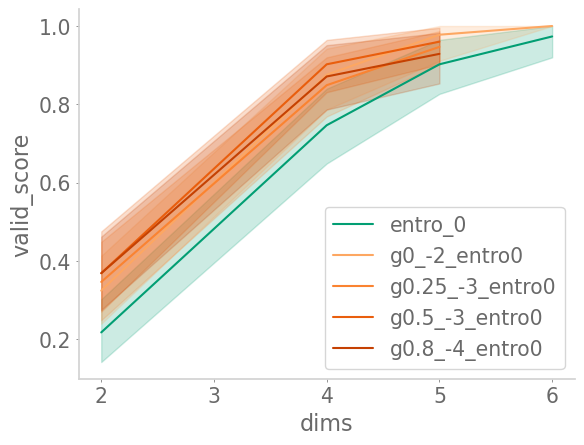

In [211]:
fig, ax = plt.subplots()
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
for idx, f in enumerate(['mf', 'entro_0', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0']):
    dd = taskA_df[(taskA_df['episode']==200) & (taskA_df['model']==f)].copy()
    sns.lineplot(
        x='dims', y='valid_score', 
        data=dd, estimator='mean',
        ax=ax, label=f, color=colors[idx]
    )
plt.legend()
plt.show()

# Transfer Results

In [212]:
zs = np.arange(2, 20)

In [213]:
taskB_df = get_df('frozentransfer_gridworld8x8', zs)

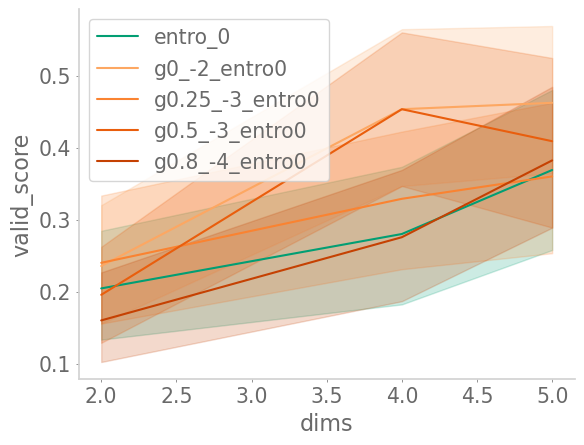

In [216]:
fig, ax = plt.subplots()
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
for idx, f in enumerate(['mf', 'entro_0', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0']):
    dd = taskB_df[(taskB_df['episode']==150) & (taskB_df['model']==f)].copy()
    sns.lineplot(
        x='dims', y='valid_score', 
        data=dd, estimator='mean',
        ax=ax, label=f, color=colors[idx]
    )
plt.legend()
plt.show()

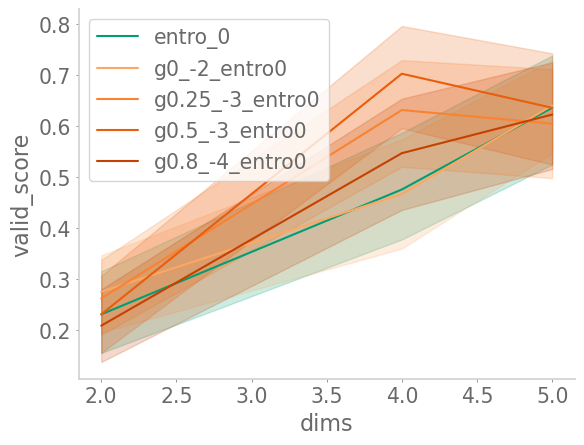

In [215]:
fig, ax = plt.subplots()
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
for idx, f in enumerate(['mf', 'entro_0', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0']):
    dd = taskB_df[(taskB_df['episode']==300) & (taskB_df['model']==f)].copy()
    sns.lineplot(
        x='dims', y='valid_score', 
        data=dd, estimator='mean',
        ax=ax, label=f, color=colors[idx]
    )
plt.legend()
plt.show()

/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


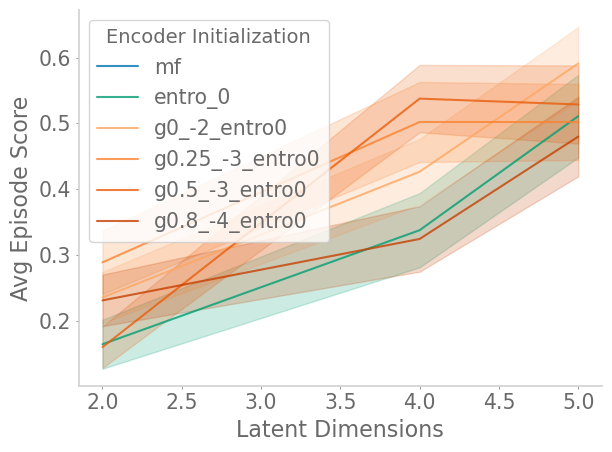

In [218]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    200,
    smooth_line=False, smooth_n=10,
    fnames=['mf', 'entro_0', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0'],
    smooth_plot=False,
    figname='gridworld8x8_taskB_late', legend_title='Encoder Initialization',
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
     )

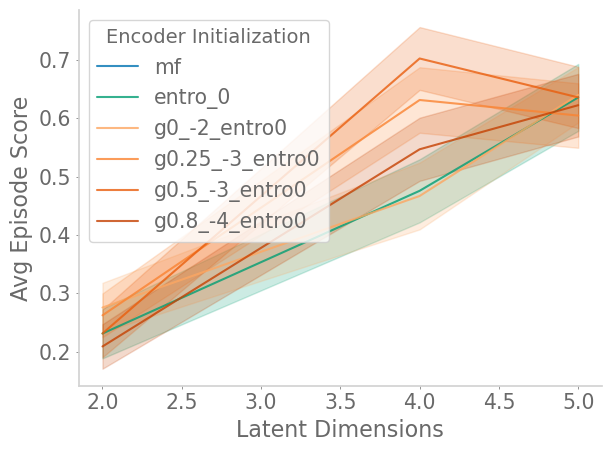

In [219]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    300,
    smooth_line=False, smooth_n=10,
    fnames=['mf', 'entro_0', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0'],
    smooth_plot=False,
    figname='gridworld8x8_taskB_late', legend_title='Encoder Initialization',
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
     )